In [1]:
import csv
import os
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import glob
from path import Path
from fklab.io import neuralynx as nlx
    

def generate_frames(index, nb_dropped_frames):
    new_list = []
    for i in range(nb_dropped_frames):
        new_list.append(index + i + 1 )
    return(new_list)

def update_dropped_frames(dropped_frames, index, nb_dropped_frames):
    incremented_dropped_frames = list(map(lambda x : x + nb_dropped_frames, dropped_frames))
    return generate_frames(index, nb_dropped_frames) + incremented_dropped_frames

def expected_frames(index):
    return math.floor((sysClock[index] - (expected_start_time - threshold_margin))/frame_period)

def cumulated_dropped_frames(index):
    return expected_frames(index) - index

def dropped_frames(sysClock):
    dropped_frames=[]
    previous_cumulated_dropped_frames = cumulated_dropped_frames(len(sysClock)-1)
    for index in reversed(range(len(sysClock))):
        new_cumulated_dropped_frames = cumulated_dropped_frames(index)
        if new_cumulated_dropped_frames < previous_cumulated_dropped_frames:
            nb_dropped_frames = previous_cumulated_dropped_frames - new_cumulated_dropped_frames
            dropped_frames = update_dropped_frames(dropped_frames, index, nb_dropped_frames)
            previous_cumulated_dropped_frames = new_cumulated_dropped_frames
    return dropped_frames

def difference_Neuralynx_fixed_miniscope(df_list, rank):
    return(sysClock_added_frames[rank]- df_list[rank])

def difference_Neuralynx_miniscope(miniscope_df_30Hz_list, rank):
    return(sysClock[rank]- miniscope_df_30Hz_list[rank])

def difference(rank):
    theoretical_timestamp=expected_start_time + (rank)*frame_period
    return(sysClock[rank]-theoretical_timestamp(rank))

# 1. import Neuralynx timestamp

In [3]:
path = Path("/media/chaeyoungkim/Samsung_T5/Miniscope project/Data/Ephys/MD21/2020-08-01_13-26-07")
#path = Path("path to neuralynx folder")

os.chdir(path)
scriptdirectory = os.getcwd()    
 
#load Neuralynx events
"""Set .env files folder """
nev_file_list = glob.glob('./*.nev')
event_file = nlx.NlxOpen(nev_file_list[0])
 

#get time from nev file
time = event_file.data[0:][0]
 
#get event from nev file
event = event_file.data[0:][1]
 
#create time_event_table
time_event_table = pd.DataFrame({'time': time, 'event': event})

miniscope    = time_event_table['event']==b'miniscope'
miniscope_df = time_event_table[miniscope]

## 1-1. Miniscope timestamp in Neuralynx

5526


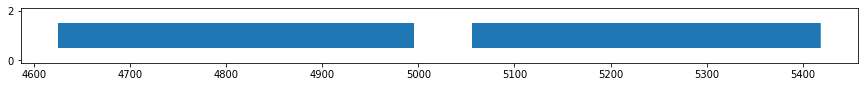

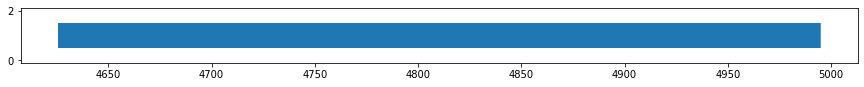

In [4]:
#plot miniscope input

miniscope = miniscope_df['time']
miniscope = miniscope.tolist()

plt.figure(figsize=(15, 1))
plt.eventplot(miniscope) 


#Spontaneous
#slice frames of interest by time
spon_miniscope = (miniscope_df[(miniscope_df['time']>4600) &(miniscope_df['time']<5000)])
spon_miniscope = spon_miniscope['time']
spon_miniscope = list(spon_miniscope)
print(len(spon_miniscope))

plt.figure(figsize=(15, 1))
plt.eventplot(spon_miniscope) 


## 1-2. Calculate total recording time for each session

In [5]:
print("Neuralynx recording duration: spontaneous")
print(spon_miniscope[-1]-spon_miniscope[0])


Neuralynx recording duration: spontaneous
368.5413440000002


## 1-3. create interpolated miniscope timestamp: 15->30Hz

In [6]:
#spontaneous
#start from 0ms 
miniscope_df_spon_from_start = []
for i in range(len(spon_miniscope)):
    from_start=spon_miniscope[i]-spon_miniscope[0]
    miniscope_df_spon_from_start.append(from_start)

#add additional lines between current timestamps (15->30Hz)
miniscope_df_spon_from_start_30Hz=[]
for i in range(len(miniscope_df_spon_from_start)-1):
    new_timestamp=(miniscope_df_spon_from_start[i]+miniscope_df_spon_from_start[i+1])/2
    miniscope_df_spon_from_start_30Hz.append(new_timestamp)
miniscope_df_spon_from_start_30Hz=miniscope_df_spon_from_start_30Hz+miniscope_df_spon_from_start
miniscope_df_spon_from_start_30Hz.sort()

miniscope_df_spon_from_start_30Hz = [element * 1000 for element in miniscope_df_spon_from_start_30Hz]
print(len(miniscope_df_spon_from_start_30Hz))
print(len(miniscope_df_spon_from_start))


11051
5526


## 1-4. Calculate miniscope frame frequency

In [7]:
#spontaneous
print(len(spon_miniscope))
print(1/((spon_miniscope[-1] - spon_miniscope[0])/(len(spon_miniscope)-1)/2))
FRAME_FREQUENCY_spon= 1/((spon_miniscope[-1] - spon_miniscope[0])/(len(spon_miniscope)-1)/2)


5526
29.983067517114154


# 2. import Miniscope timestamp 

11024


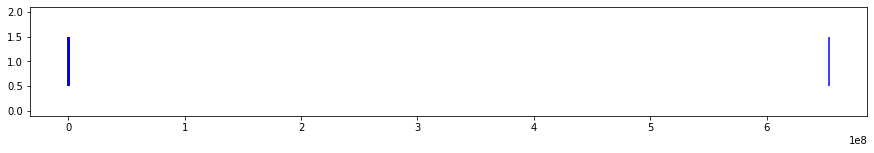

In [9]:
path_spon = Path("/media/chaeyoungkim/Samsung_T52/Miniscope project/data/Miniscope data/MD21/8_1_2020_recording3/1_nostim/H21_M33_S16")
#path_spon = Path("Path to miniscope timestamp.dat file")

os.chdir(path_spon)
    
columns_to_keep = ['camNum', 'frameNum', 'sysClock', 'buffer']
df = pd.read_table("timestamp.dat", sep="\s+", usecols=columns_to_keep)  

sysClock=list(df['sysClock']) #saved time in miniscope software
print(len(sysClock))

#FRAME_FREQUENCY = FRAME_FREQUENCY_disruption #Hz, from Neuralynx timestamp. calculate for each data. Has to be very precise (at least until 3rd decimal)
frame_period = 1000/FRAME_FREQUENCY_spon #ms
threshold_margin = frame_period/2
expected_start_time = sysClock[1] - frame_period #because sysClock[0] is an absolute start time

fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(15,2))
plt.eventplot(sysClock, color='blue')



# 3. Detect dropped frames

Dropped frame list : 
[1978, 2919, 3006, 3469, 3594, 3910, 4588, 4692, 4701, 5312, 5433, 5567, 5757, 6011, 6135, 6804, 6821, 6900, 7804, 8045, 8173, 8265, 8611, 9400, 10078, 10101, 10105, 10106, 10316]
29


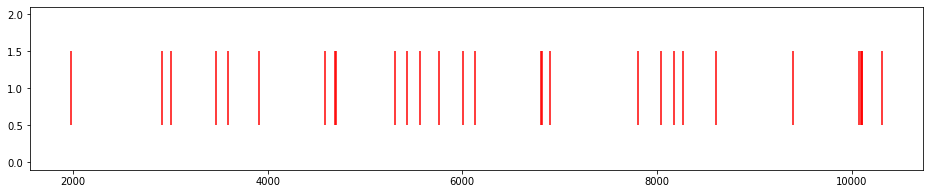

In [10]:
dropped_frame_list=dropped_frames(sysClock)
print("Dropped frame list : ")
print(dropped_frame_list)
print(len(dropped_frame_list)) #Neuralynx frame number

fig, ax = plt.subplots(1,1, sharex=False, sharey=True, figsize=(16,3))
plt.eventplot(dropped_frame_list, color='red')

# 3. Plot time difference: Neuralynx-Miniscope

(-100.0, 1100.0)

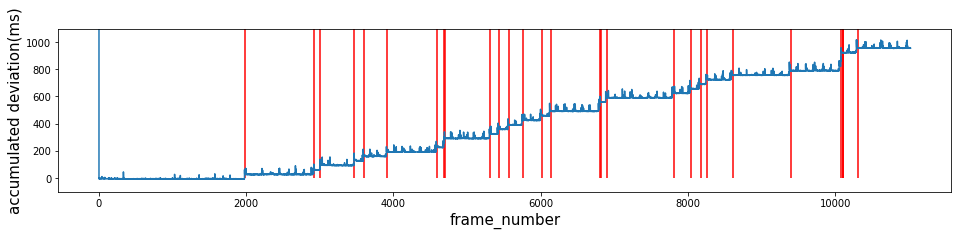

In [11]:
#plot difference:
plot=[]
for x in range(len(sysClock)):
    plot.append(difference_Neuralynx_miniscope(miniscope_df_spon_from_start_30Hz, x))

fig, ax = plt.subplots(1,1, sharex=False, sharey=True, figsize=(16,3))
plt.plot(range(len(plot)), plot)
plt.vlines(dropped_frame_list, 0, 3300, color='red')
plt.ylabel("accumulated deviation(ms)", fontsize=15 )
plt.xlabel("frame_number", fontsize=15)
plt.ylim(-100,1100)

# 5. Insert missing frames to the miniscope sysClock

In [13]:
#sysClock
sysClock_added_frames= sysClock.copy()

for i in dropped_frame_list:
    sysClock_added_frames.insert(i, sysClock_added_frames[i-1]+frame_period)

print(len(sysClock_added_frames))
print(len(sysClock))


11053
11024


# 6. Plot difference: Neuralynx - corrected miniscope timestamps

Frame_difference :
29
Approx. time_difference (ms):
-963.5315000003902


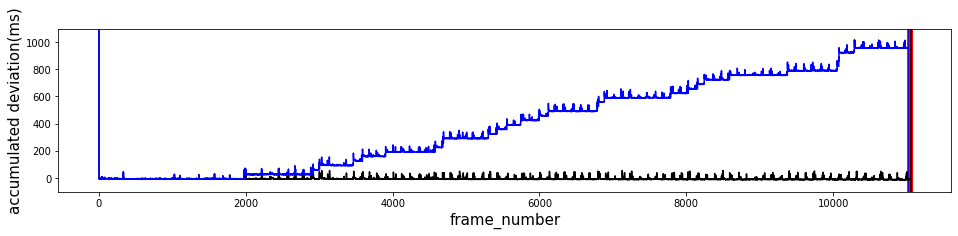

In [14]:
plot_fix=[]

for x in range(len(miniscope_df_spon_from_start_30Hz)):
    plot_fix.append(difference_Neuralynx_fixed_miniscope(miniscope_df_spon_from_start_30Hz,x)) 
 
fig, ax = plt.subplots(1,1, sharex=False, sharey=True, figsize=(16,3))
plt.plot(range(len(plot_fix)), plot_fix,'k')
plt.plot(range(len(plot)), plot,'b')

plt.vlines(len(miniscope_df_spon_from_start_30Hz), -100, 3300, 'r', lw=5)
plt.vlines(len(sysClock_added_frames), -100, 3300, 'k')
plt.vlines(len(sysClock), -100, 3300,'b')

plt.ylabel("accumulated deviation(ms)", fontsize=15 )
plt.xlabel("frame_number", fontsize=15)
plt.ylim(-100, 1100)

print("Frame_difference :")
print(len(sysClock_added_frames)-len(sysClock))

print("Approx. time_difference (ms):")
print(plot_fix[-1]-plot[-1])